# Automated ML

Import Dependencies

In [5]:
import os
import numpy as np
import pandas as pd
import json
import requests
from numpy import array
from azureml.automl.runtime.onnx_convert import OnnxConverter
from azureml.core import Workspace, Experiment
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.core.run import Run
from azureml.data.dataset_factory import TabularDatasetFactory
from azureml.widgets import RunDetails
from azureml.train.sklearn import SKLearn
from azureml.train.automl import AutoMLConfig
from azureml.core import ScriptRunConfig, Environment, Dataset
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix

## Dataset

### Overview
This dataset is called the Mushroom Classification dataset from Kaggle, source: https://www.kaggle.com/uciml/mushroom-classification.

The goal is to be able to accurately identify poisonous and edible mushrooms based on the features and qualities provided.

"This dataset includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family Mushroom drawn from The Audubon Society Field Guide to North American Mushrooms (1981). Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous one. The Guide clearly states that there is no simple rule for determining the edibility of a mushroom; no rule like "leaflets three, let it be'' for Poisonous Oak and Ivy."

In [6]:
ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

experiment_name = 'mushroom-classification-final'

experiment=Experiment(ws, experiment_name)
experiment

sandbox-main
main-workspace
westus2
095d396f-a6aa-423a-90bb-d2146baff999


Name,Workspace,Report Page,Docs Page
mushroom-classification-final,sandbox-main,Link to Azure Machine Learning studio,Link to Documentation


## Compute

In [7]:
amlcompute_cluster_name = "default-ds2"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS_V2',
                                                           max_nodes=4)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)
print(compute_target.get_status().serialize())

Found existing cluster, use it.

Running
{'errors': [], 'creationTime': '2021-03-01T23:09:59.409359+00:00', 'createdBy': {'userObjectId': '616470c5-2ea0-40e6-bcb4-c19a2983c934', 'userTenantId': '891fb020-7b98-4908-8912-9521f813ddf0', 'userName': None}, 'modifiedTime': '2021-03-01T23:12:30.874963+00:00', 'state': 'Running', 'vmSize': 'STANDARD_DS2_V2'}


## Data Processing
Here I will clean the data and prepare it to be used in the AutoML runs. This will require removing null entries, making sure the data is properly encoded and I will provide some graphs and charts that showcase the data as well.

I chose to delete the veil color and gill-attachment fields because they contained the same value for every entry so the impact they had was negligible.

I wanted to see if there was a difference between One Hot Encoding and Label Encoding for a classification problem like this so I did runs using both. The results were that they gave about the same results and took about the same amount of time to run so it didn't really matter how i encoded it.

In [8]:
#Obtain / register dataset if it does not already exist in the workspace
found = False
key = "mushroom-classification"
description_text = "features to classify whether or not a mushroom is poisonous or edible"

if key in ws.datasets.keys(): 
        found = True
        dataset = ws.datasets[key] 
        print("Found registered dataset, using...")

if not found:
        # Create AML Dataset and register it into Workspace
        datapath = "https://raw.githubusercontent.com/huxfrank/nd00333-capstone/master/starter_file/mushroom-classification/mushrooms.csv"
        dataset = Dataset.Tabular.from_delimited_files(datapath)  

        #Register Dataset in Workspace
        print("Registering new dataset...")
        dataset = dataset.register(workspace=ws,
                                   name=key,
                                   description=description_text)


df = dataset.to_pandas_dataframe()
df.describe()

Found registered dataset, using...


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,7914,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,1,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,False,n,False,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [9]:
#Clean data for null entries
df.isnull().sum()

class                         0
cap-shape                     0
cap-surface                   0
cap-color                     0
bruises                       0
odor                          0
gill-attachment             210
gill-spacing                  0
gill-size                     0
gill-color                    0
stalk-shape                   0
stalk-root                    0
stalk-surface-above-ring      0
stalk-surface-below-ring      0
stalk-color-above-ring        0
stalk-color-below-ring        0
veil-type                     0
veil-color                    0
ring-number                   0
ring-type                     0
spore-print-color             0
population                    0
habitat                       0
dtype: int64

In [10]:
#One Hot Encoding

#Delete veil type and gill attachment because it's the same value for all entries
del df['veil-type']
del df['gill-attachment']

ohc = pd.get_dummies(df, drop_first = True)
ohc.head()

,bruises,class_p,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_g,cap-surface_s,cap-surface_y,...,population_n,population_s,population_v,population_y,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,True,1,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,1,0
1,True,0,0,0,0,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,0
2,True,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
3,True,1,0,0,0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,1,0
4,False,0,0,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [11]:
#Label Encoding
for col in df.columns:
    label_encoder = LabelEncoder()
    feature = df[str(col)]
    label_encoder.fit(feature)
    print(feature.name, label_encoder.classes_)
    df[str(col)] = label_encoder.transform(feature)

df.head()

class ['e' 'p']
cap-shape ['b' 'c' 'f' 'k' 's' 'x']
cap-surface ['f' 'g' 's' 'y']
cap-color ['b' 'c' 'e' 'g' 'n' 'p' 'r' 'u' 'w' 'y']
bruises [False  True]
odor ['a' 'c' 'f' 'l' 'm' 'n' 'p' 's' 'y']
gill-spacing ['c' 'w']
gill-size ['b' 'n']
gill-color ['b' 'e' 'g' 'h' 'k' 'n' 'o' 'p' 'r' 'u' 'w' 'y']
stalk-shape ['e' 't']
stalk-root ['?' 'b' 'c' 'e' 'r']
stalk-surface-above-ring ['f' 'k' 's' 'y']
stalk-surface-below-ring ['f' 'k' 's' 'y']
stalk-color-above-ring ['b' 'c' 'e' 'g' 'n' 'o' 'p' 'w' 'y']
stalk-color-below-ring ['b' 'c' 'e' 'g' 'n' 'o' 'p' 'w' 'y']
veil-color ['n' 'o' 'w' 'y']
ring-number ['n' 'o' 't']
ring-type ['e' 'f' 'l' 'n' 'p']
spore-print-color ['b' 'h' 'k' 'n' 'o' 'r' 'u' 'w' 'y']
population ['a' 'c' 'n' 's' 'v' 'y']
habitat ['d' 'g' 'l' 'm' 'p' 'u' 'w']


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,0,1,4,0,...,2,2,7,7,2,1,4,2,3,5
1,0,5,2,9,1,0,0,0,4,0,...,2,2,7,7,2,1,4,3,2,1
2,0,0,2,8,1,3,0,0,5,0,...,2,2,7,7,2,1,4,3,2,3
3,1,5,3,8,1,6,0,1,5,0,...,2,2,7,7,2,1,4,2,3,5
4,0,5,2,3,0,5,1,0,4,1,...,2,2,7,7,2,1,0,3,0,1


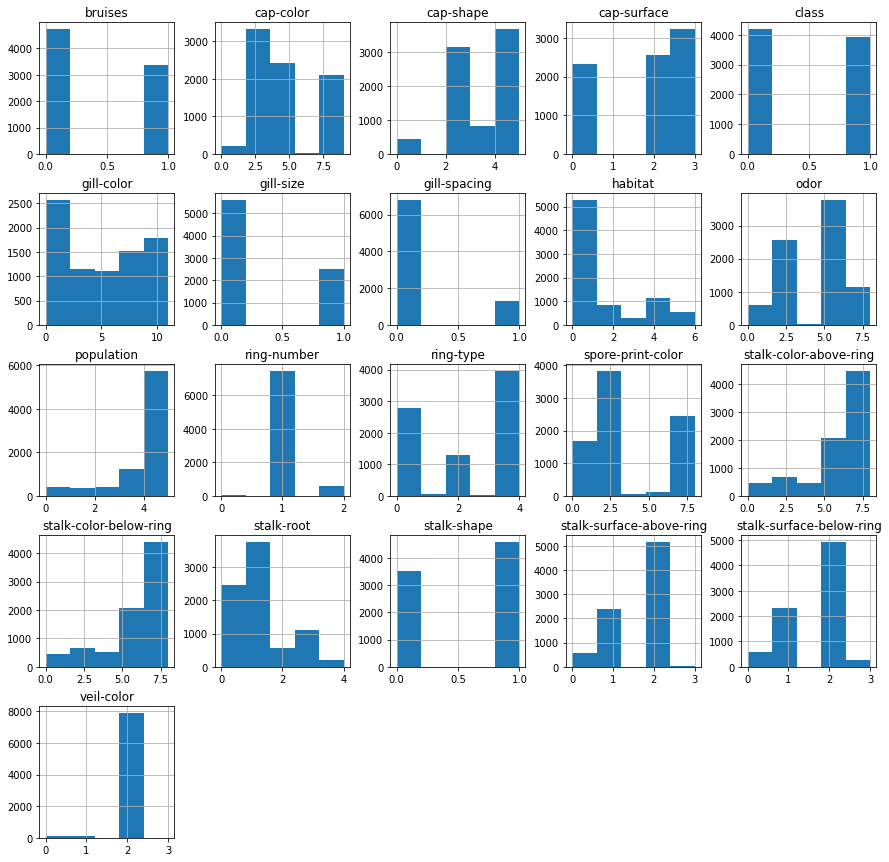

In [12]:
#View of features post label-encoding
df.hist(bins=5, figsize=(15,15));

In [13]:
#Split encoded data into independent and dependent variables to scale dependent data

lc_y = df["class"]
lc_x = df.drop("class", axis = 1)

#Standardization of Features for Label Encoded Data
scaler = StandardScaler()

lc_x = pd.DataFrame(scaler.fit_transform(lc_x), columns = lc_x.columns)
lc_x.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1.03,0.14,-0.20,1.19,0.88,-0.44,1.49,-0.23,-1.14,1.78,0.68,0.59,0.62,0.63,0.14,-0.26,0.95,-0.67,-0.51,2.03
1,1.03,0.14,1.77,1.19,-1.97,-0.44,-0.67,-0.23,-1.14,0.84,0.68,0.59,0.62,0.63,0.14,-0.26,0.95,-0.25,-1.31,-0.30
2,-2.09,0.14,1.37,1.19,-0.54,-0.44,-0.67,0.05,-1.14,0.84,0.68,0.59,0.62,0.63,0.14,-0.26,0.95,-0.25,-1.31,0.87
3,1.03,0.95,1.37,1.19,0.88,-0.44,1.49,0.05,-1.14,1.78,0.68,0.59,0.62,0.63,0.14,-0.26,0.95,-0.67,-0.51,2.03
4,1.03,0.14,-0.59,-0.84,0.41,2.28,-0.67,-0.23,0.87,1.78,0.68,0.59,0.62,0.63,0.14,-0.26,-1.27,-0.25,-2.91,-0.30


In [14]:
#Rejoin Y with X data
lc = lc_x.join(lc_y)

lc.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,1.03,0.14,-0.20,1.19,0.88,-0.44,1.49,-0.23,-1.14,1.78,...,0.59,0.62,0.63,0.14,-0.26,0.95,-0.67,-0.51,2.03,1
1,1.03,0.14,1.77,1.19,-1.97,-0.44,-0.67,-0.23,-1.14,0.84,...,0.59,0.62,0.63,0.14,-0.26,0.95,-0.25,-1.31,-0.30,0
2,-2.09,0.14,1.37,1.19,-0.54,-0.44,-0.67,0.05,-1.14,0.84,...,0.59,0.62,0.63,0.14,-0.26,0.95,-0.25,-1.31,0.87,0
3,1.03,0.95,1.37,1.19,0.88,-0.44,1.49,0.05,-1.14,1.78,...,0.59,0.62,0.63,0.14,-0.26,0.95,-0.67,-0.51,2.03,1
4,1.03,0.14,-0.59,-0.84,0.41,2.28,-0.67,-0.23,0.87,1.78,...,0.59,0.62,0.63,0.14,-0.26,-1.27,-0.25,-2.91,-0.30,0


# AutoML Configuration
Here I ran both types of encoding to see if it would affect the results and which one worked better for this kind of problem. I used the same settings for both types of runs to see if it would be a factor in my results but I got roughly the same results from both encoding types which tells me that for this problem, either type of encoding was acceptable.

## AutoML Runs
For both the OHC and the Label Encoding runs, I chose an experiment timeout of 30 minutes to start and I was going to raise it if needed but all my runs finished within the time limit so this works.
Early stopping is a good thing to have because it means your model won't continuously run algorithms that give the same results if no improvement is found, it conserves resources and time.
Each iteration timeout I set to 5 because it was a default value I found in a previous project but it seems to be working fine, I was prepared to raise it as soon as it seemed like it was interfering with my results.
The max concurrent iterations is set to 2 because I have a max of 2 cores on my compute.

I chose accuracy as my primary metric because this is a classification problem and accuracy in determining poisonous and edible is the ultimate goal. I set cross validations to 5 because my dataset is not massive (relative to some of the others out there) so I felt this was enough. I also enabled ONXX compatibility so I can save my model to the ONXX store. I discovered that the ONXX compatibility models enabled option was throwing warnings but it was still in the AzureML documentation so I was unsure how to reconcile that issue.

In [15]:
#AutoML settings for both runs
automl_settings = {
                    "experiment_timeout_hours" : 0.5,
                    "enable_early_stopping" : True,
                    "iteration_timeout_minutes": 5,
                    "max_concurrent_iterations": 2,
                    "max_cores_per_iteration": -1,
                    "featurization": 'auto',
                    "verbosity": logging.INFO,
                }
#One Hot Encoding AutoMLConfig
ohc_config = AutoMLConfig(
    task="classification",
    primary_metric='accuracy',
    training_data=ohc,
    label_column_name='class_p',
    enable_onnx_compatible_models=True,
    n_cross_validations=5,
    **automl_settings
    )

In [16]:
#Submit your experiment
exp = Experiment(ws,"mushroom_ohc_automl")
ohc_run = experiment.submit(ohc_config, show_output = True)

No run_configuration provided, running on local with default configuration
Running on local machine
Parent Run ID: AutoML_92f091ad-ff17-4c7b-9489-4d7c9791b535

Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

**************************************************

In [17]:
RunDetails(ohc_run).show()
ohc_run.wait_for_completion()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

{'runId': 'AutoML_92f091ad-ff17-4c7b-9489-4d7c9791b535',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2021-04-20T00:36:37.576239Z',
 'endTimeUtc': '2021-04-20T00:52:20.251737Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '5',
  'target': 'local',
  'AMLSettingsJsonString': '{"path":null,"name":"mushroom-classification-final","subscription_id":"095d396f-a6aa-423a-90bb-d2146baff999","resource_group":"main-workspace","workspace_name":"sandbox-main","region":"westus2","compute_target":"local","spark_service":null,"azure_service":"Microsoft.AzureNotebookVM","many_models":false,"pipeline_fetch_max_batch_size":1,"iterations":1000,"primary_metric":"accuracy","task_type":"classification","data_script":null,"validation_size":0.0,"n_cross_validations":5,"y_min":null,"y_max":null,"num_classes":2,"featurizatio

In [18]:
#AutoML Run with Label Encoded Data

label_config = AutoMLConfig(
    task="classification",
    primary_metric='accuracy',
    training_data=lc,
    label_column_name='class',
    enable_onxx_compatible_models=True,
    n_cross_validations=5,
    **automl_settings
    )

In [19]:
exp = Experiment(ws,"mushroom_lc_automl")
label_run = experiment.submit(label_config, show_output = True)

No run_configuration provided, running on local with default configuration
Running on local machine
Parent Run ID: AutoML_0f0242a2-125f-4e57-b0f1-4e024d00d463

Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

**************************************************

## Run Details

In [20]:
RunDetails(label_run).show()
label_run.wait_for_completion()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

{'runId': 'AutoML_0f0242a2-125f-4e57-b0f1-4e024d00d463',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2021-04-20T00:55:14.639352Z',
 'endTimeUtc': '2021-04-20T01:12:31.448908Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '5',
  'target': 'local',
  'AMLSettingsJsonString': '{"path":null,"name":"mushroom-classification-final","subscription_id":"095d396f-a6aa-423a-90bb-d2146baff999","resource_group":"main-workspace","workspace_name":"sandbox-main","region":"westus2","compute_target":"local","spark_service":null,"azure_service":"Microsoft.AzureNotebookVM","many_models":false,"pipeline_fetch_max_batch_size":1,"iterations":1000,"primary_metric":"accuracy","task_type":"classification","data_script":null,"validation_size":0.0,"n_cross_validations":5,"y_min":null,"y_max":null,"num_classes":2,"featurizatio

## Best Model

TODO: In the cell below, get the best model from the automl experiments and display all the properties of the model.



In [21]:
best_run, onxx_model = label_run.get_output(return_onxx_model = True)
print(best_run)
print(onxx_model)

Run(Experiment: mushroom-classification-final,
Id: AutoML_0f0242a2-125f-4e57-b0f1-4e024d00d463_31,
Type: None,
Status: Completed)
Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('prefittedsoftvotingclassifier',...
                                                                                                num_leaves=80,
                                                                                                objective=None,
                                       

In [22]:
best_run_customized, fitted_model_customized = label_run.get_output()

custom_featurizer = fitted_model_customized.named_steps['datatransformer']
df = custom_featurizer.get_featurization_summary()
pd.DataFrame(data=df)


,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,bruises,Numeric,No,9,[MeanImputer]
1,cap-color,Numeric,No,9,[MeanImputer]
2,cap-shape,Numeric,No,9,[MeanImputer]
3,cap-surface,Numeric,No,9,[MeanImputer]
4,gill-color,Numeric,No,9,[MeanImputer]
5,gill-size,Numeric,No,9,[MeanImputer]
6,gill-spacing,Numeric,No,9,[MeanImputer]
7,habitat,Numeric,No,9,[MeanImputer]
8,odor,Numeric,No,9,[MeanImputer]
9,population,Numeric,No,9,[MeanImputer]


In [24]:
#TODO: Save the best model
best_run, onnx_mdl = label_run.get_output(return_onnx_model=True)

onnx_fl_path = "./best_model.onnx"
OnnxConverter.save_onnx_model(onnx_mdl, onnx_fl_path)

OnnxConvertException: OnnxConvertException:
	Message: Requested an ONNX compatible model but the run has ONNX compatibility disabled.
	InnerException: None
	ErrorResponse 
{
    "error": {
        "code": "UserError",
        "message": "Requested an ONNX compatible model but the run has ONNX compatibility disabled.",
        "target": "onnx_compatible",
        "inner_error": {
            "code": "BadArgument",
            "inner_error": {
                "code": "ArgumentInvalid"
            }
        }
    }
}

## Model Deployment

In [25]:
#Get best run
best_run, fitted_model = label_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: mushroom-classification-final,
Id: AutoML_0f0242a2-125f-4e57-b0f1-4e024d00d463_31,
Type: None,
Status: Completed)
Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('prefittedsoftvotingclassifier',...
                                                                                                num_leaves=80,
                                                                                                objective=None,
                                       

In [26]:
#Save model and prepare scoring script
model_name = best_run.properties['model_name']

script_file_name = 'inference/score.py'

best_run.download_file('outputs/scoring_file_v_1_0_0.py', 'inference/score.py')

description = 'Auto ML Model trained on mushroom classification data, label encoded'
tags = None
model = label_run.register_model(model_name = model_name, description = description, tags = tags)

print(label_run.model_id)

AutoML0f0242a2131


## Test Model

In [29]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment
from azureml.automl.core.shared import constants

#I trained this model locally, creating environment
best_run.download_file(constants.CONDA_ENV_FILE_PATH, 'myenv.yml')
myenv = Environment.from_conda_specification(name="myenv", file_path="myenv.yml")
inference_config = InferenceConfig(entry_script="inference/score.py", environment=myenv)

#Deploying ACI Service
aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {'area': "bmData", 'type': "automl_classification"}, 
                                               description = 'service for Automl Classification')

aci_service_name = 'automl-mushroom-classification-l'
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

automl-mushroom-classification-l
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running........................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [30]:
#Test dataframes are lc_y and lc_x
#Running lc_x data through ACI service to get prediction results, y_pred

X_test_json = lc_x.to_json(orient='records')
data = "{\"data\": " + X_test_json +"}"
headers = {'Content-Type': 'application/json'}

resp = requests.post(aci_service.scoring_uri, data, headers=headers)

y_pred = json.loads(json.loads(resp.text))['result']

In [31]:
#Making sure the same number of results were returned from the service as the actual results
actual = array(lc_y)
print(len(y_pred), " ", len(actual))

8124   8124


In [34]:
#Confusion Matrix
cf =confusion_matrix(actual,y_pred)
print(cf)

[[4158   50]
 [ 140 3776]]


In [33]:
#Service Logs
aci_service.get_logs()

'2021-04-20T01:23:15,698803300+00:00 - gunicorn/run \n2021-04-20T01:23:15,712412500+00:00 - rsyslog/run \n2021-04-20T01:23:15,744598000+00:00 - iot-server/run \n2021-04-20T01:23:15,784822000+00:00 - nginx/run \n/usr/sbin/nginx: /azureml-envs/azureml_6f3791fe7434448b4ebe2b0fd691d644/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_6f3791fe7434448b4ebe2b0fd691d644/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_6f3791fe7434448b4ebe2b0fd691d644/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_6f3791fe7434448b4ebe2b0fd691d644/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_6f3791fe7434448b4ebe2b0fd691d644/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)

In [35]:
#Clean up - delete service and compute
aci_service.delete()
compute_target.delete()